In [137]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

In [138]:
df = pd.read_csv('data/arianagrande.csv')
df = df.drop(df[df.release_date == 'None'].index, axis=0)
df = df.reset_index().drop('index', axis=1)
df

,api_path,primary_artist,title,url,song_endpoint,album,release_date,lyrics
0,/songs/4067762,Ariana Grande,7 rings,https://genius.com/Ariana-grande-7-rings-lyrics,http://api.genius.com/songs/4067762,"thank u, next",2019-01-18,"Yeah, breakfast at Tiffany's and bottles of b..."
1,/songs/3056610,Ariana Grande,ABC,https://genius.com/Ariana-grande-abc-lyrics,http://api.genius.com/songs/3056610,None,2009-06-25,A-buh-buh-buh-buh-buh (a-buh-buh-buh-buh-buh)...
2,/songs/4476779,Ariana Grande,ACT II SWT,https://genius.com/Ariana-grande-act-ii-swt-ly...,http://api.genius.com/songs/4476779,None,2019-04-01,"Last night, boy, I met you, yeah *kneels* Whe..."
3,/songs/4472102,Ariana Grande,ACT I : SWT,https://genius.com/Ariana-grande-act-i-swt-lyrics,http://api.genius.com/songs/4472102,None,2019-04-01,When raindrops fell Down from the sky The day...
4,/songs/1968727,Ariana Grande,All I Want for Christmas Is You,https://genius.com/Ariana-grande-all-i-want-fo...,http://api.genius.com/songs/1968727,None,2019-04-01,I don't want a lot for Christmas There is just...
5,/songs/203953,Ariana Grande,Almost Is Never Enough,https://genius.com/Ariana-grande-almost-is-nev...,http://api.genius.com/songs/203953,Yours Truly,2013-08-19,I'd like to say we gave it a try I'd like to ...
6,/songs/192859,Ariana Grande,Baby I,https://genius.com/Ariana-grande-baby-i-lyrics,http://api.genius.com/songs/192859,Yours Truly,2013-07-22,"Baby, I got love for thee so deep inside of m..."
7,/songs/4278902,Ariana Grande,Baby Loves,https://genius.com/Ariana-grande-baby-loves-ly...,http://api.genius.com/songs/4278902,None,2019-04-01,"Baby loves, I'm tryna talk to you There's a bo..."
8,/songs/4154699,Ariana Grande,Baby Loves (Intro),https://genius.com/Ariana-grande-baby-loves-in...,http://api.genius.com/songs/4154699,Dangerous Woman,2017-02-03,"Baby loves, I'm tryna talk to you There’s a b..."
9,/songs/2457505,Ariana Grande,Bad Decisions,https://genius.com/Ariana-grande-bad-decisions...,http://api.genius.com/songs/2457505,Dangerous Woman,2016-05-20,"Boy, you know that you drive me crazy But it'..."


In [139]:
df.shape

(134, 8)

In [140]:
df.isna().sum()

api_path          0
primary_artist    0
title             0
url               0
song_endpoint     0
album             0
release_date      0
lyrics            0
dtype: int64

In [141]:
lexicon = pd.read_csv('sentiment_lexicons/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', delim_whitespace=True, header=None)
lexicon.head()

,0,1,2
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


In [142]:
rs_lexicon = lexicon.pivot(index=0, columns=1, values=2)
rs_lexicon.drop(rs_lexicon.index[0], axis=0, inplace=True)
rs_lexicon.head()

1,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0


In [143]:
for col in rs_lexicon.columns:
    print(f'{col}: {rs_lexicon[col].sum()}')

anger: 1247
anticipation: 839
disgust: 1058
fear: 1476
joy: 689
negative: 3324
positive: 2312
sadness: 1191
surprise: 534
trust: 1231


In [144]:
vocabulary = list(rs_lexicon.index)
emotions = {}
for word in vocabulary:
    rs_lex_filtered = rs_lexicon.loc[[word]]
    values = [col for col in rs_lex_filtered.columns if int(rs_lex_filtered[col].values) == 1]
    if values != []:
        emotions[word] = values

In [145]:
emotions

{'abacus': ['trust'],
 'abandon': ['fear', 'negative', 'sadness'],
 'abandoned': ['anger', 'fear', 'negative', 'sadness'],
 'abandonment': ['anger', 'fear', 'negative', 'sadness', 'surprise'],
 'abba': ['positive'],
 'abbot': ['trust'],
 'abduction': ['fear', 'negative', 'sadness', 'surprise'],
 'aberrant': ['negative'],
 'aberration': ['disgust', 'negative'],
 'abhor': ['anger', 'disgust', 'fear', 'negative'],
 'abhorrent': ['anger', 'disgust', 'fear', 'negative'],
 'ability': ['positive'],
 'abject': ['disgust', 'negative'],
 'abnormal': ['disgust', 'negative'],
 'abolish': ['anger', 'negative'],
 'abolition': ['negative'],
 'abominable': ['disgust', 'fear', 'negative'],
 'abomination': ['anger', 'disgust', 'fear', 'negative'],
 'abort': ['negative'],
 'abortion': ['disgust', 'fear', 'negative', 'sadness'],
 'abortive': ['negative', 'sadness'],
 'abovementioned': ['positive'],
 'abrasion': ['negative'],
 'abrogate': ['negative'],
 'abrupt': ['surprise'],
 'abscess': ['negative', 'sad

In [146]:
corpus = []
tokenizer = RegexpTokenizer(r'\w\w+') 
lemmatizer = WordNetLemmatizer()
for lyric in df['lyrics']:
    token = tokenizer.tokenize(str(lyric).lower())
    lemmatized_token = []
    for word in token:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_token.append(lemmatized_word)
    corpus.append(lemmatized_token)

In [147]:
song_emotions = []
for song in corpus:
    emotion_count = {'anger': 0, 
                     'positive': 0,
                     'negative': 0,
                     'anticipation': 0, 
                     'disgust': 0,
                     'fear': 0, 
                     'joy': 0, 
                     'sadness': 0, 
                     'surprise': 0, 
                     'trust': 0} 
    for word in song:
        if word in emotions.keys():
            word_emotions = emotions[word]
            for emotion in word_emotions:
                emotion_count[emotion] += 1
    song_emotions.append(emotion_count)

In [148]:
len(song_emotions)

134

In [149]:
song_emotions

[{'anger': 12,
  'positive': 19,
  'negative': 17,
  'anticipation': 10,
  'disgust': 5,
  'fear': 8,
  'joy': 14,
  'sadness': 8,
  'surprise': 5,
  'trust': 13},
 {'anger': 1,
  'positive': 29,
  'negative': 10,
  'anticipation': 3,
  'disgust': 11,
  'fear': 0,
  'joy': 25,
  'sadness': 2,
  'surprise': 3,
  'trust': 9},
 {'anger': 12,
  'positive': 73,
  'negative': 44,
  'anticipation': 31,
  'disgust': 19,
  'fear': 11,
  'joy': 50,
  'sadness': 12,
  'surprise': 15,
  'trust': 54},
 {'anger': 27,
  'positive': 47,
  'negative': 67,
  'anticipation': 21,
  'disgust': 19,
  'fear': 30,
  'joy': 32,
  'sadness': 22,
  'surprise': 11,
  'trust': 34},
 {'anger': 2,
  'positive': 29,
  'negative': 0,
  'anticipation': 8,
  'disgust': 2,
  'fear': 0,
  'joy': 22,
  'sadness': 0,
  'surprise': 6,
  'trust': 16},
 {'anger': 10,
  'positive': 22,
  'negative': 9,
  'anticipation': 7,
  'disgust': 6,
  'fear': 4,
  'joy': 17,
  'sadness': 5,
  'surprise': 4,
  'trust': 10},
 {'anger': 12,


In [150]:
df = df.join(pd.DataFrame(song_emotions), how='left')

In [151]:
df.isna().sum()

api_path          0
primary_artist    0
title             0
url               0
song_endpoint     0
album             0
release_date      0
lyrics            0
anger             0
anticipation      0
disgust           0
fear              0
joy               0
negative          0
positive          0
sadness           0
surprise          0
trust             0
dtype: int64

# 1. Sentiment analysis over time

In [152]:
df_normalized = df.groupby('release_date')[['anger', 'positive', 'negative', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']].sum()

df_normalized.head()
for col in df_normalized.columns:
    df_normalized[col] = df_normalized[col].apply(int)

In [153]:
sums = df_normalized['anger'] + df_normalized['positive'] + df_normalized['negative'] + df_normalized['anticipation'] + df_normalized['disgust'] + df_normalized['fear'] + df_normalized['joy'] + df_normalized['sadness'] + df_normalized['surprise'] + df_normalized['trust']   
df_normalized['sum'] = sums
df_normalized.head()

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
2008-09-30,0,2,0,0,0,1,2,0,0,3,8
2008-10-22,5,10,7,2,4,7,6,7,5,6,59
2008-12-07,0,9,1,5,0,0,5,1,4,5,30
2009-01-13,1,34,9,4,2,1,26,5,3,11,96
2009-06-25,1,29,10,3,11,0,25,2,3,9,93


In [154]:
df_normalized.index = pd.to_datetime(df_normalized.index)
df_normalized = df_normalized.resample('Y').sum()
df_normalized.head()

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
2008-12-31,5,21,8,7,4,8,13,8,9,14,97
2009-12-31,2,63,19,7,13,1,51,7,6,20,189
2010-12-31,22,37,45,19,21,19,21,31,7,17,239
2011-12-31,13,72,54,21,24,40,53,46,14,30,367
2012-12-31,21,128,48,34,26,34,95,25,19,52,482


In [155]:
cols = list(df_normalized.columns)
zeros = (df_normalized.anger == 0) & (df_normalized.positive == 0) & (df_normalized.negative == 0) & (df_normalized.anticipation == 0) & (df_normalized.disgust == 0) & (df_normalized.fear == 0) & (df_normalized.joy == 0) & (df_normalized.sadness == 0) & (df_normalized.surprise == 0) & (df_normalized.trust == 0) 
df_normalized.drop(df_normalized[zeros].index, axis=0, inplace=True)
df_normalized

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
2008-12-31,5,21,8,7,4,8,13,8,9,14,97
2009-12-31,2,63,19,7,13,1,51,7,6,20,189
2010-12-31,22,37,45,19,21,19,21,31,7,17,239
2011-12-31,13,72,54,21,24,40,53,46,14,30,367
2012-12-31,21,128,48,34,26,34,95,25,19,52,482
2013-12-31,97,629,224,173,95,93,460,94,104,210,2179
2014-12-31,67,318,171,106,69,80,214,81,67,180,1353
2015-12-31,25,321,80,96,51,34,182,20,28,128,965
2016-12-31,204,524,447,154,228,134,342,128,87,253,2501


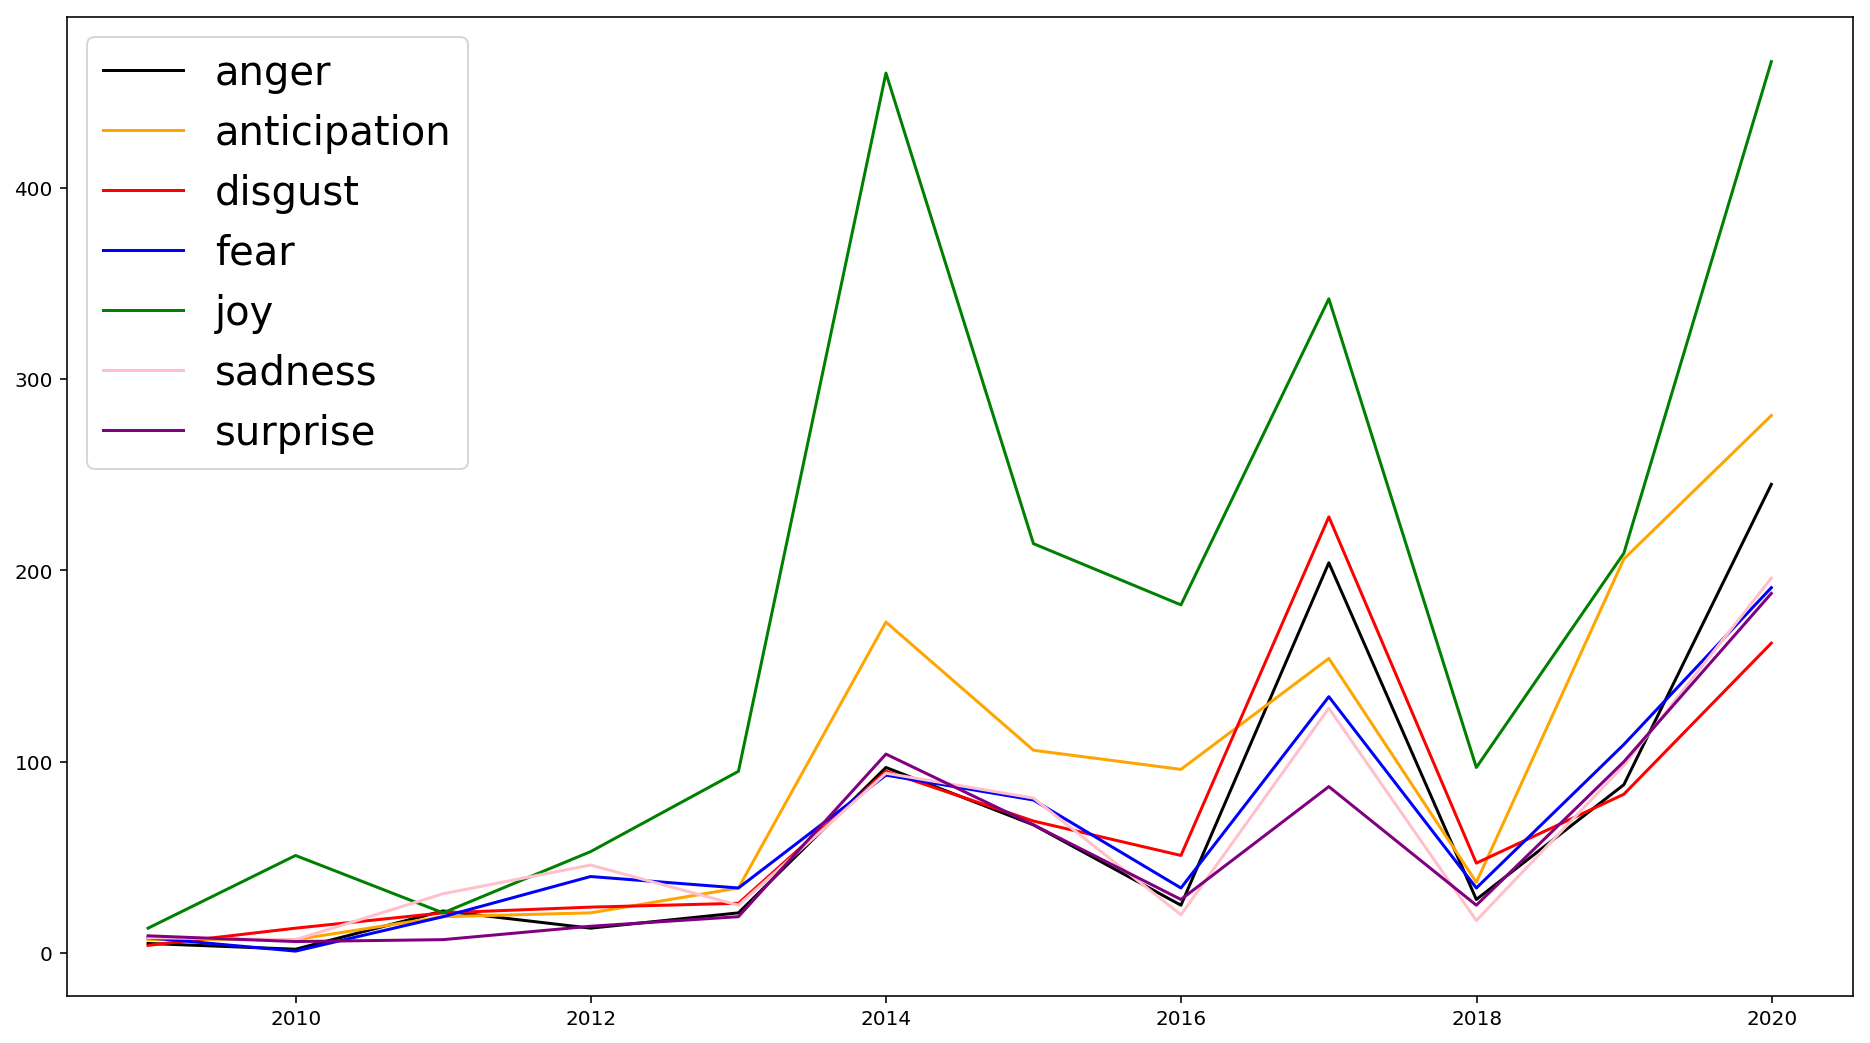

In [156]:
plt.figure(figsize=(16, 9))
plt.plot(df_normalized.index, df_normalized.anger, label='anger', c='k');
plt.plot(df_normalized.index, df_normalized.anticipation, label='anticipation', c='orange');
plt.plot(df_normalized.index, df_normalized.disgust, label='disgust', c='red');
plt.plot(df_normalized.index, df_normalized.fear, label='fear', c='blue');
plt.plot(df_normalized.index, df_normalized.joy, label='joy', c='green');
plt.plot(df_normalized.index, df_normalized.sadness, label='sadness', c='pink');
plt.plot(df_normalized.index, df_normalized.surprise, label='surprise', c='purple');
plt.legend(fontsize=20);

In [157]:
cols.remove('sum')
for col in cols:
    df_normalized[col] = df_normalized[col] / df_normalized['sum']

In [158]:
df_normalized

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
2008-12-31,0.051546,0.216495,0.082474,0.072165,0.041237,0.082474,0.134021,0.082474,0.092784,0.144330,97
2009-12-31,0.010582,0.333333,0.100529,0.037037,0.068783,0.005291,0.269841,0.037037,0.031746,0.105820,189
2010-12-31,0.092050,0.154812,0.188285,0.079498,0.087866,0.079498,0.087866,0.129707,0.029289,0.071130,239
2011-12-31,0.035422,0.196185,0.147139,0.057221,0.065395,0.108992,0.144414,0.125341,0.038147,0.081744,367
2012-12-31,0.043568,0.265560,0.099585,0.070539,0.053942,0.070539,0.197095,0.051867,0.039419,0.107884,482
2013-12-31,0.044516,0.288665,0.102799,0.079394,0.043598,0.042680,0.211106,0.043139,0.047728,0.096374,2179
2014-12-31,0.049520,0.235033,0.126386,0.078344,0.050998,0.059128,0.158167,0.059867,0.049520,0.133038,1353
2015-12-31,0.025907,0.332642,0.082902,0.099482,0.052850,0.035233,0.188601,0.020725,0.029016,0.132642,965
2016-12-31,0.081567,0.209516,0.178729,0.061575,0.091164,0.053579,0.136745,0.051180,0.034786,0.101160,2501


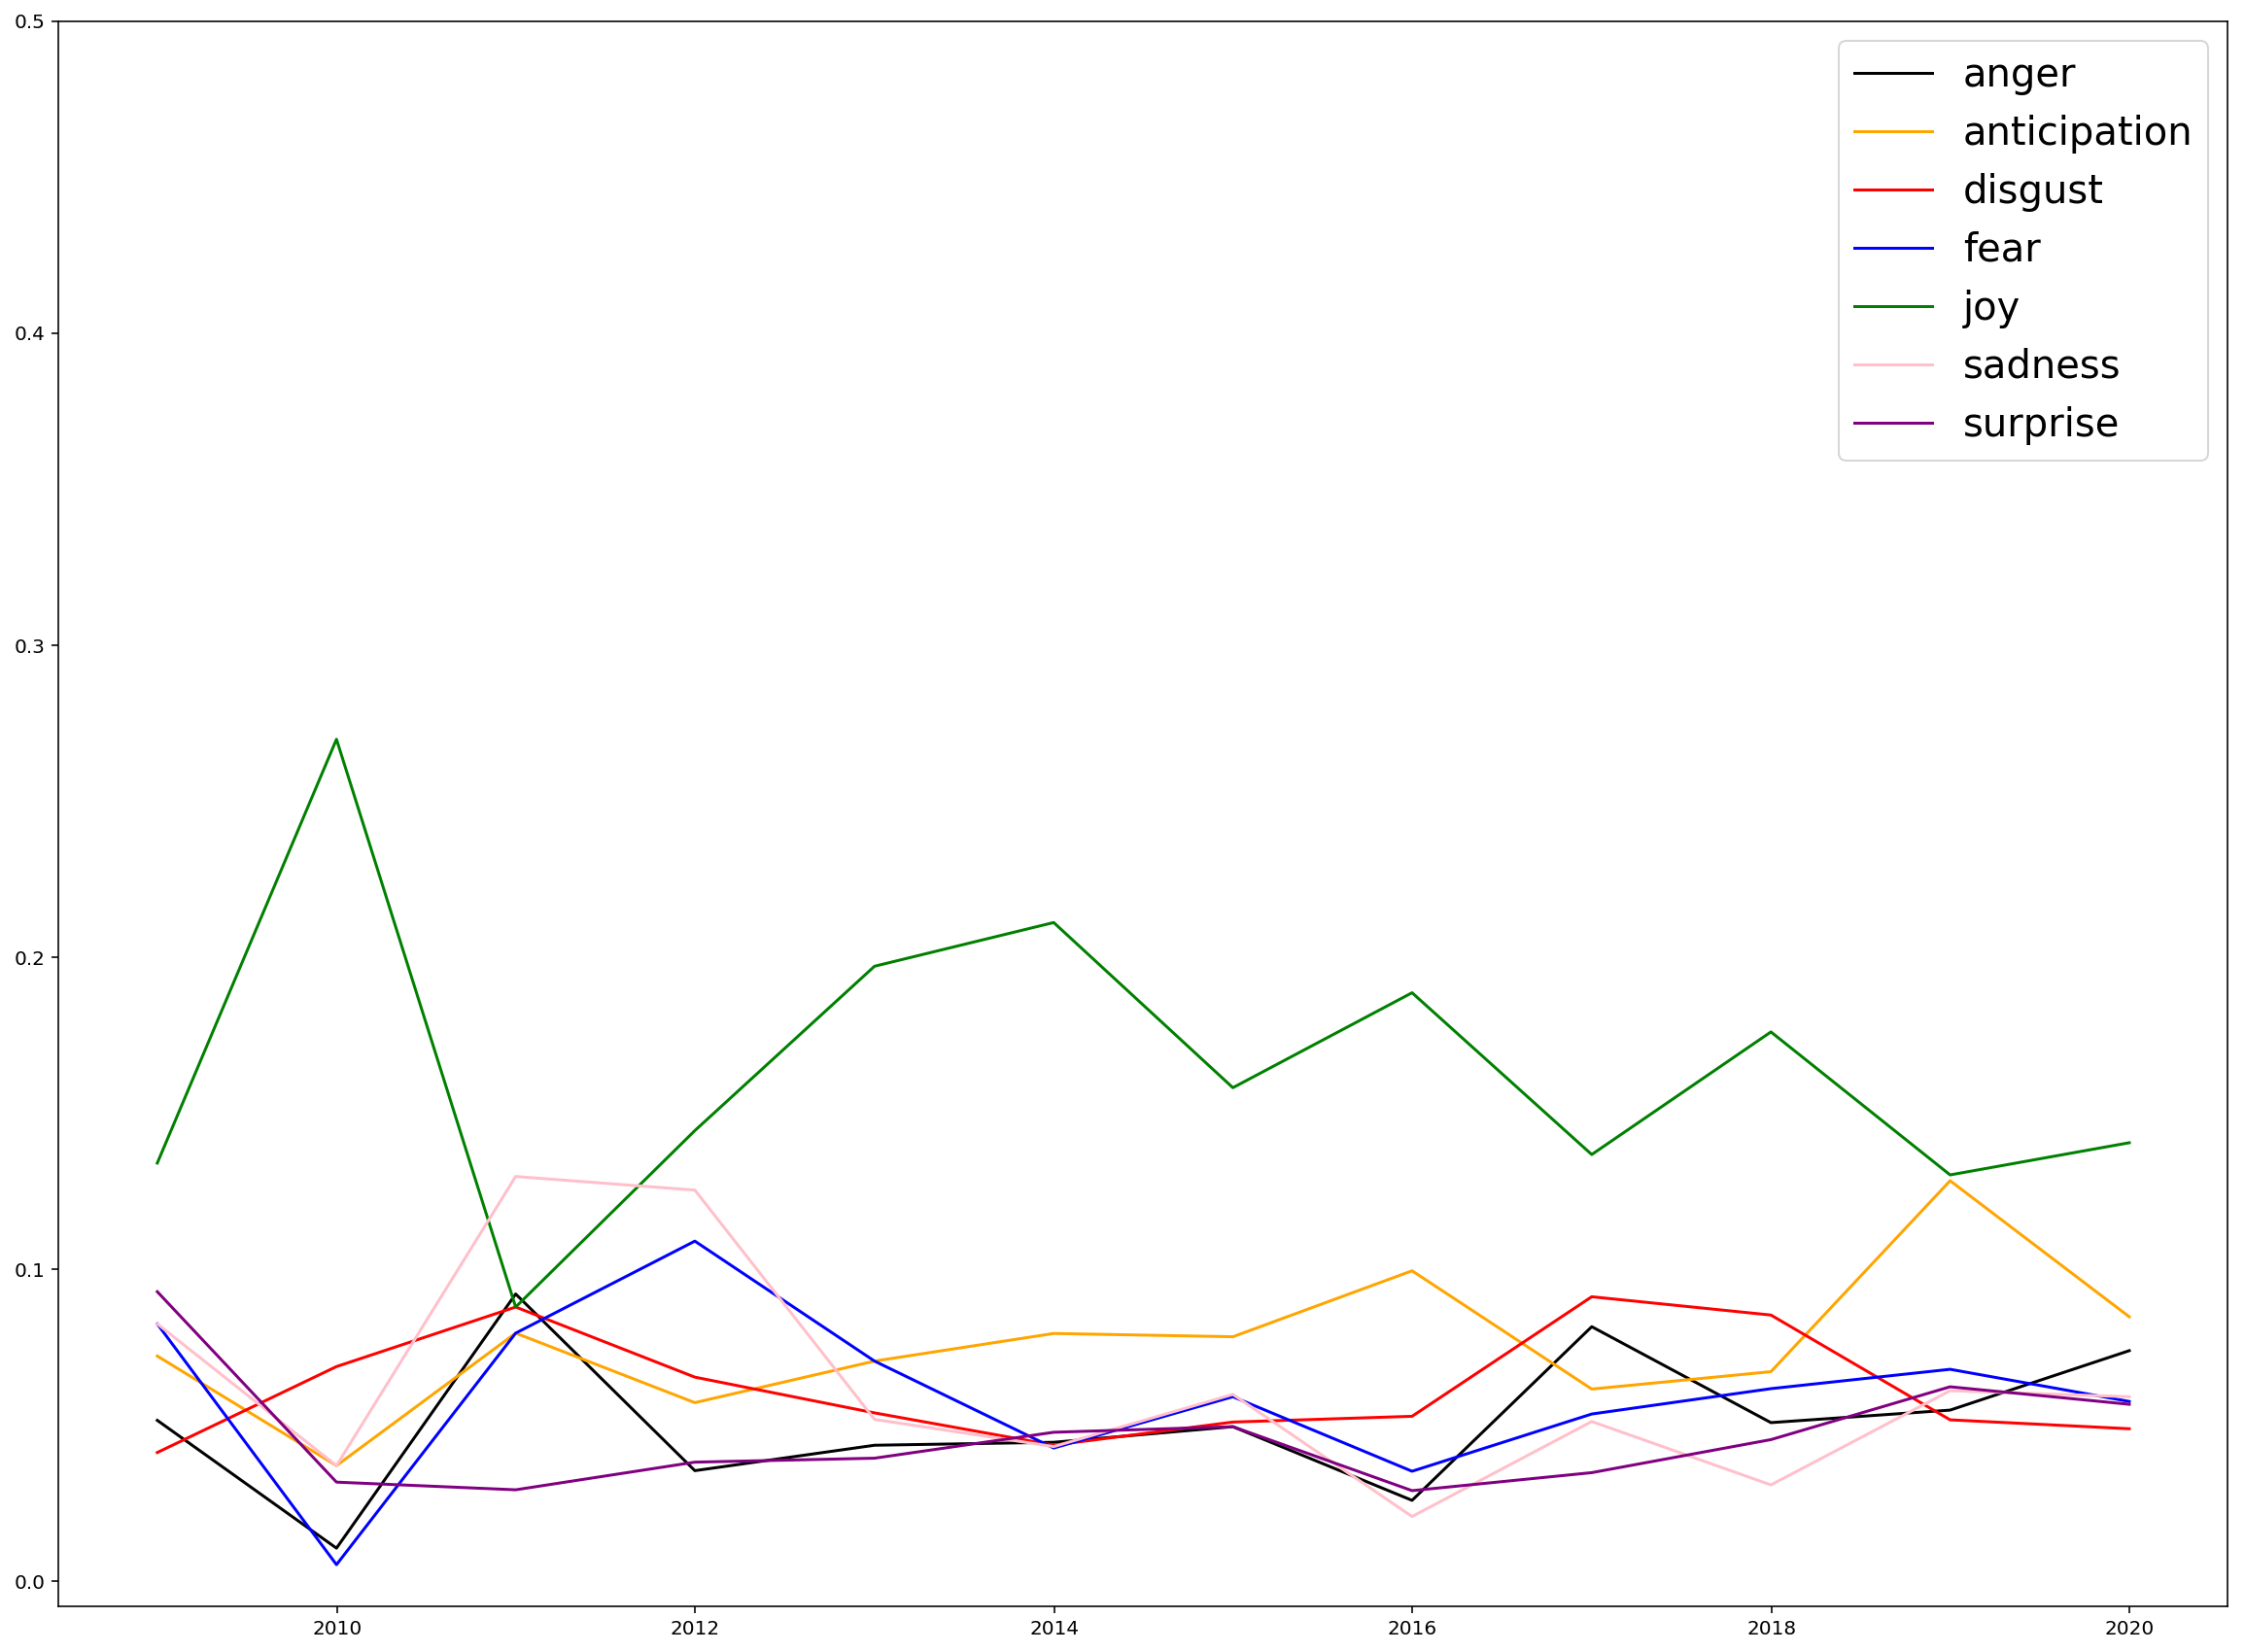

In [159]:
plt.figure(figsize=(20, 15))
plt.plot(df_normalized.index, df_normalized.anger, label='anger', c='k');
plt.plot(df_normalized.index, df_normalized.anticipation, label='anticipation', c='orange');
plt.plot(df_normalized.index, df_normalized.disgust, label='disgust', c='red');
plt.plot(df_normalized.index, df_normalized.fear, label='fear', c='blue');
plt.plot(df_normalized.index, df_normalized.joy, label='joy', c='green');
plt.plot(df_normalized.index, df_normalized.sadness, label='sadness', c='pink');
plt.plot(df_normalized.index, df_normalized.surprise, label='surprise', c='purple');
plt.ylim(top=0.5)
plt.legend(fontsize=20);

# 2. Clustering songs

https://www.sciencedirect.com/topics/computer-science/cosine-similarity

In [160]:
cluster_df = df[['title', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'surprise', 'trust']]
X = cluster_df.drop(['title'], axis=1)
y = cluster_df['title']

In [161]:
X.head()

,anger,anticipation,disgust,fear,joy,surprise,trust
0,12,10,5,8,14,5,13
1,1,3,11,0,25,3,9
2,12,31,19,11,50,15,54
3,27,21,19,30,32,11,34
4,2,8,2,0,22,6,16


In [162]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [163]:
pca = PCA(n_components=2)
pca = pca.fit_transform(X)

In [164]:
KMeans = KMeans(n_clusters = 4)
KMeans.fit(pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [165]:
pca = pd.DataFrame(pca, columns = ['Component1', 'Component2'])

In [166]:
pca['cluster'] = KMeans.labels_

In [167]:
KMeans.cluster_centers_

array([[-14.1729739 ,   4.07818372],
       [ 47.26179598,   9.56116106],
       [  0.23852418,  -1.62975648],
       [ 18.43646364, -24.04299778]])

In [168]:
pca.cluster.unique()

array([2, 1, 3, 0])

In [169]:
pca.head()

,Component1,Component2,cluster
0,-0.480602,-5.607423,2
1,4.263310,8.571230,2
2,53.157030,-16.888088,1
3,32.557074,-30.884986,3
4,4.333067,6.918254,2


In [170]:
pca.cluster.value_counts()

2    58
0    54
1    12
3    10
Name: cluster, dtype: int64

In [171]:
pca[pca.cluster == 1].index

Int64Index([2, 6, 21, 26, 34, 72, 73, 74, 76, 113, 120, 125], dtype='int64')

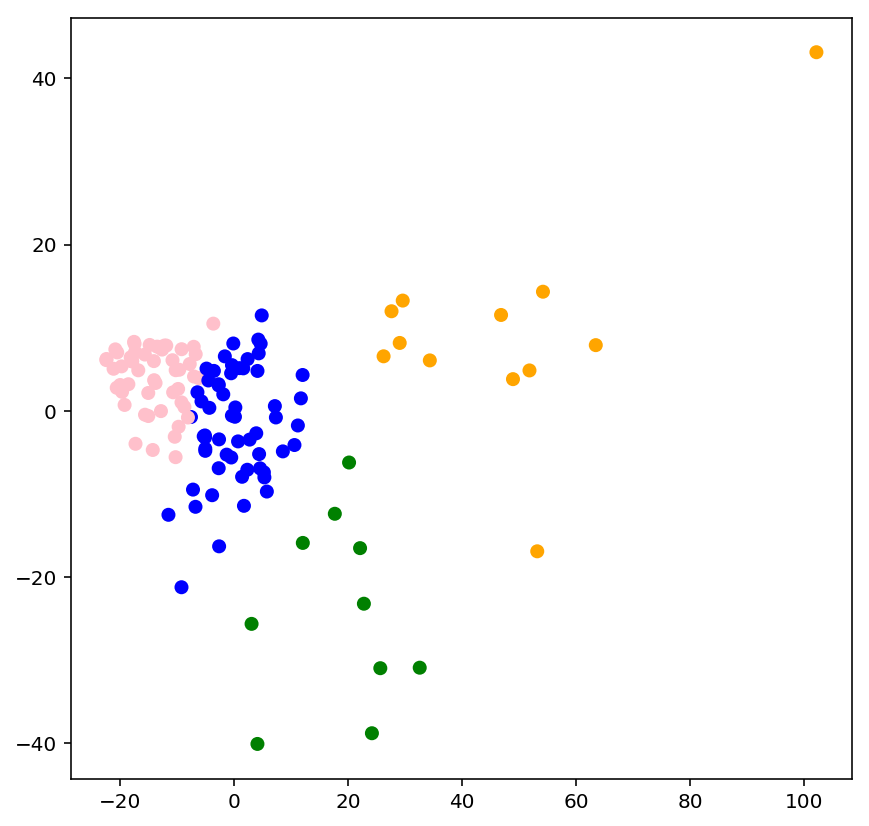

In [173]:
plt.figure(figsize=(7,7))
colors = ['pink', 'orange', 'blue', 'green']
pca['color'] = pca['cluster'].map(lambda x: colors[x])
plt.scatter(pca['Component1'], pca['Component2'], c = pca['color']);

In [174]:
from sklearn.cluster import DBSCAN

In [175]:
dbscan = DBSCAN(eps=3, min_samples=15)

In [176]:
dbscan.fit(pca[['Component1', 'Component2']])

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=15, n_jobs=None, p=None)

In [177]:
pca['dbscan'] = dbscan.labels_

In [178]:
pca.dbscan.unique()

array([-1,  0])

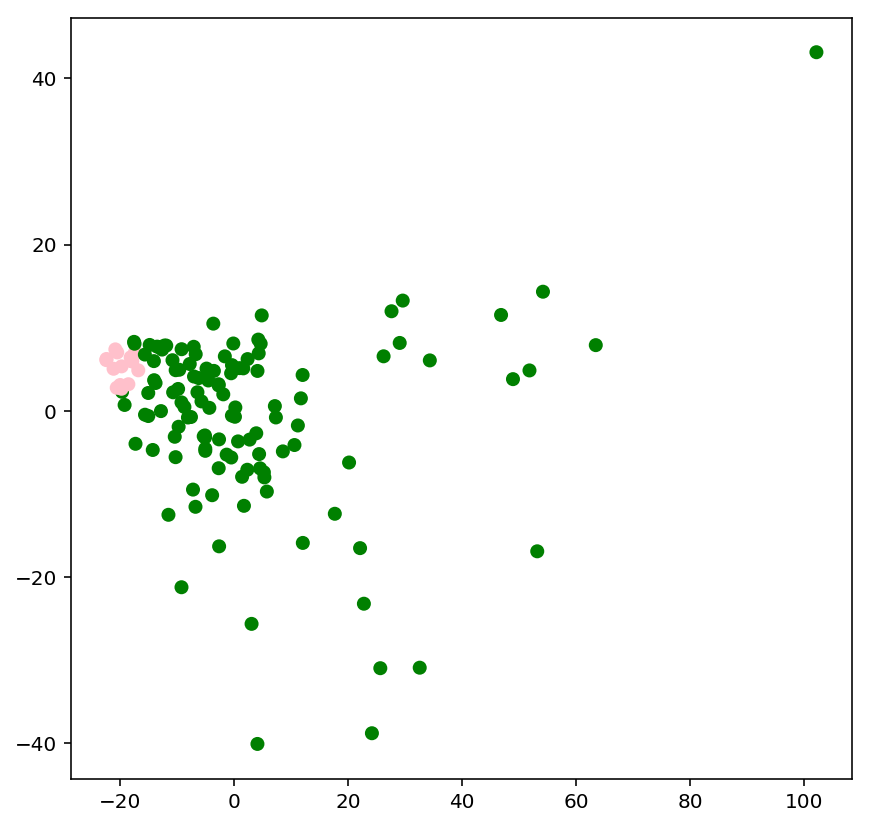

In [179]:
plt.figure(figsize=(7,7))
colors = ['pink', 'orange', 'blue', 'green']
pca['dbscan_color'] = pca['dbscan'].map(lambda x: colors[x])
plt.scatter(pca['Component1'], pca['Component2'], c = pca['dbscan_color']);

In [180]:
from sklearn.cluster import MeanShift
ms = MeanShift(bandwidth=11)
ms.fit(pca[['Component1', 'Component2']])
pca['mean_shift'] = ms.labels_
pca.mean_shift.unique()

array([0, 7, 4, 3, 8, 2, 6, 1, 5])

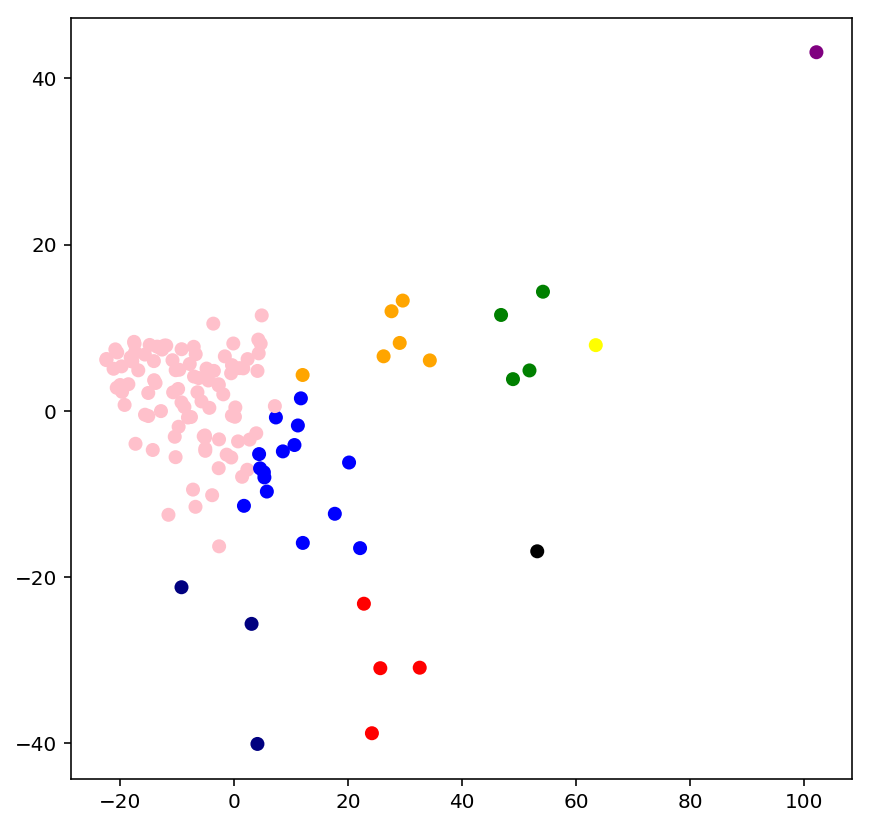

In [182]:
plt.figure(figsize=(7,7))
colors = ['pink', 'orange', 'blue', 'green', 'red', 'purple', 'yellow', 'black', 'navy']
pca['ms_color'] = pca['mean_shift'].map(lambda x: colors[x])
plt.scatter(pca['Component1'], pca['Component2'], c = pca['ms_color']);

# 3. Positivity Score

* greater than 0.05 --> positive
* between -0.05 and 0.05 --> neutral
* less than -0.05 --> negative

In [183]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [184]:
def lyrics_analyzer(lyrics):
    score = analyser.polarity_scores(lyrics)
    return score

In [185]:
polarity = []
for lyric in df['lyrics']:
    polarity.append(lyrics_analyzer(str(lyric)))

In [186]:
pd.DataFrame(polarity)['compound'].mean()

0.6548335820895519

# 4. Word Cloud

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

cv = CountVectorizer(min_df=0, stop_words="english", max_features=200)
counts = cv.fit_transform(df['lyrics'])                                               

In [188]:
words_freq = pd.DataFrame(counts.todense(), columns = cv.get_feature_names())
words_dict = {}
for word in words_freq.columns:
    words_dict[word] = words_freq[word].sum()

In [194]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wc = WordCloud(max_words=200,
               stopwords=stopwords,
               scale=3,
               height=300, 
               width=800, 
               max_font_size=80, 
               min_font_size=5,
               relative_scaling=0,
               colormap='RdPu',
               background_color='black').fit_words(words_dict)

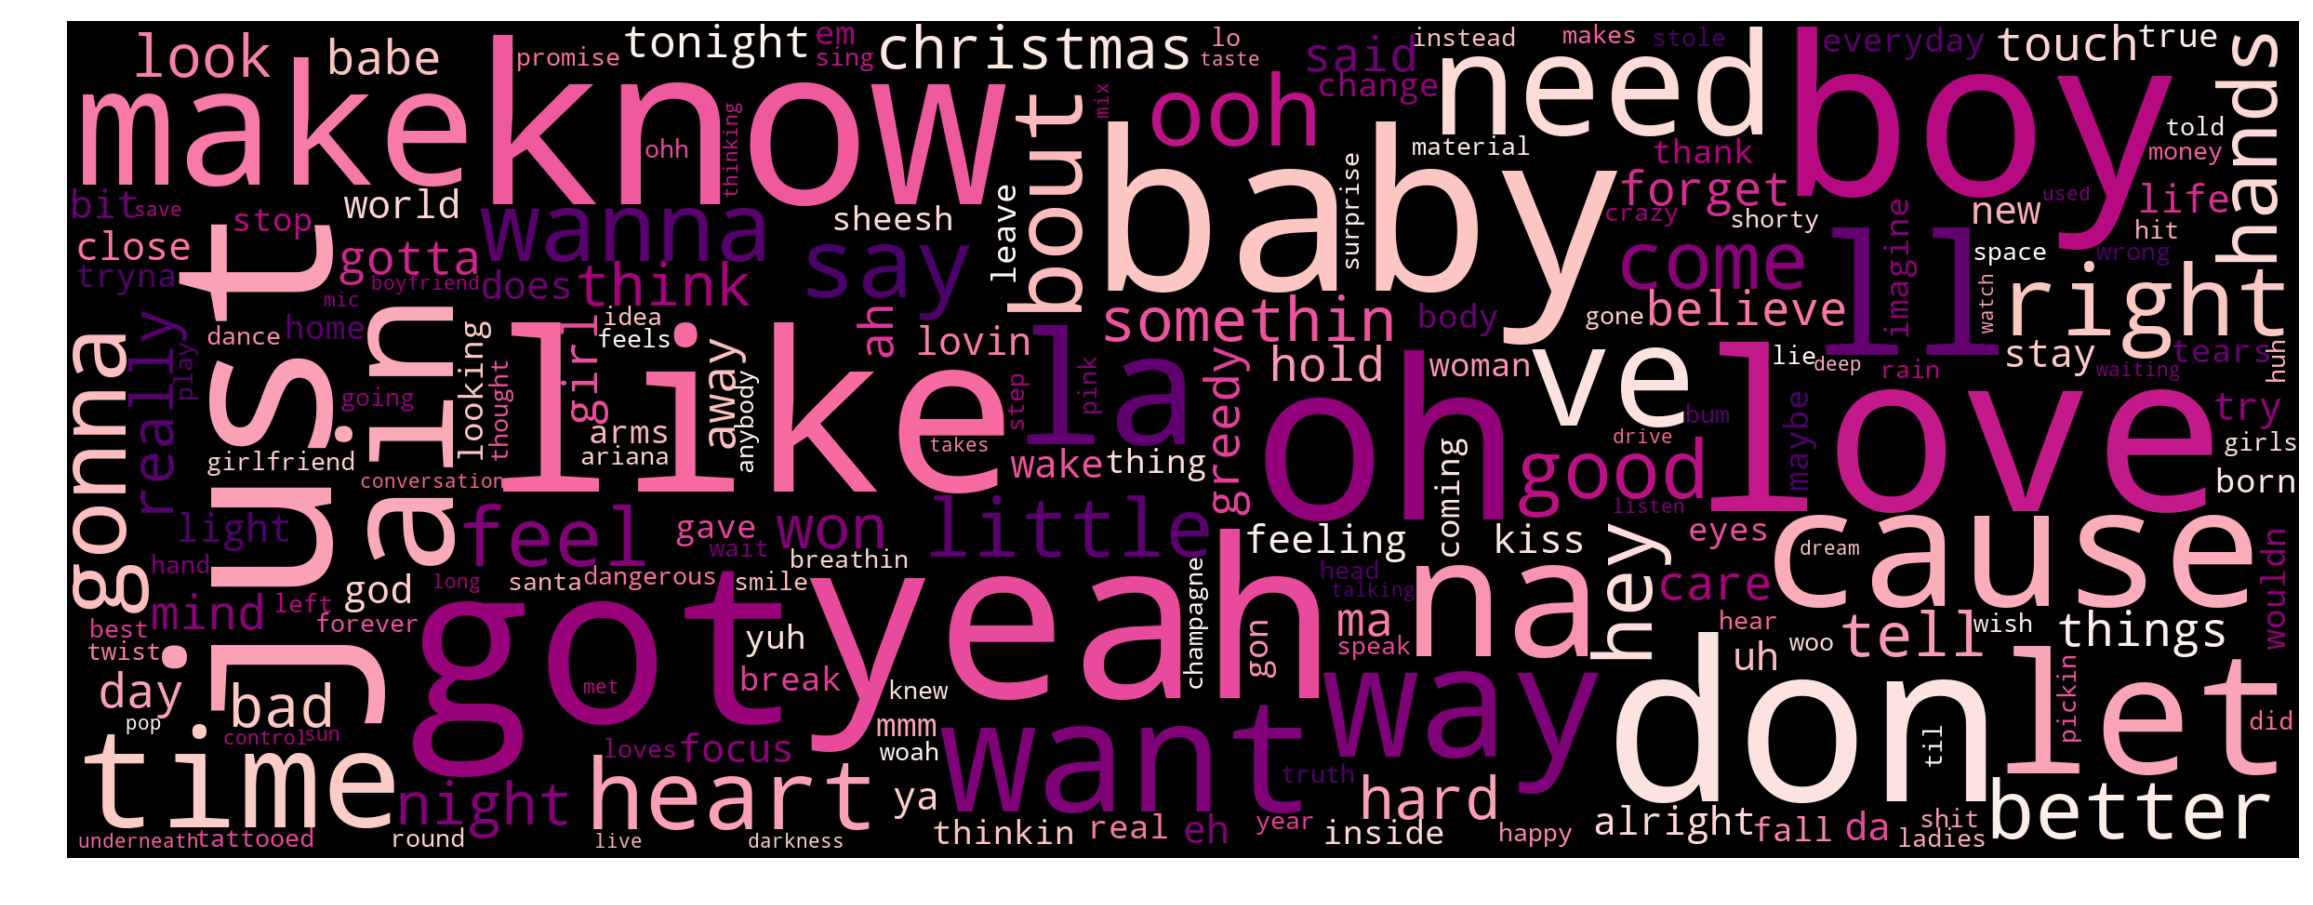

In [195]:
import random
plt.figure(figsize=[20,20])
plt.imshow(wc, interpolation="bilinear")
wc.to_file("a_new_hope.png")
plt.axis("off")
plt.show()

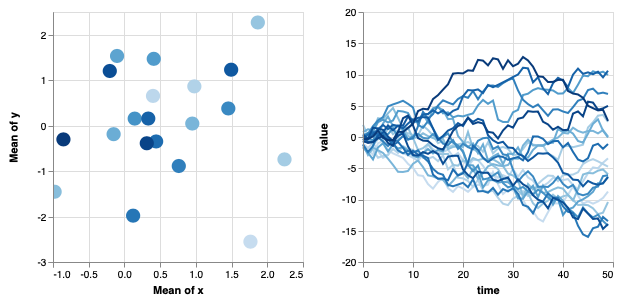

In [136]:
import altair as alt
import pandas as pd
import numpy as np
alt.renderers.enable('notebook')

np.random.seed(0)
n_objects = 20
n_times = 50

# Create one (x, y) pair of metadata per object
locations = pd.DataFrame({
    'id': range(n_objects),
    'x': np.random.randn(n_objects),
    'y': np.random.randn(n_objects)
})

# Create a 50-element time-series for each object
timeseries = pd.DataFrame(np.random.randn(n_times, n_objects).cumsum(0),
                          columns=locations['id'],
                          index=pd.RangeIndex(0, n_times, name='time'))

# Melt the wide-form timeseries into a long-form view
timeseries = timeseries.reset_index().melt('time')

# Merge the (x, y) metadata into the long-form view
timeseries['id'] = timeseries['id'].astype(int)  # make merge not complain
data = pd.merge(timeseries, locations, on='id')

# Data is prepared, now make a chart

selector = alt.selection_single(empty='all', fields=['id'])

base = alt.Chart(data).properties(
    width=250,
    height=250
).add_selection(selector)

points = base.mark_point(filled=True, size=200).encode(
    x='mean(x)',
    y='mean(y)',
    color=alt.condition(selector, 'id:O', alt.value('lightgray'), legend=None),
).interactive()

timeseries = base.mark_line().encode(
    x='time',
    y=alt.Y('value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
)

points | timeseries